In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MNIST_combined(nn.Module):
    def __init__(self):
        super(MNIST_combined, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32,
            kernel_size=5,
            stride = 1,
            padding = 2
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, 
            out_channels=64,
            kernel_size=5,
            stride = 1,
            padding = 2
        )
        self.l3 = nn.Linear(7*7*64, 1024)
        self.l_logits = nn.Linear(1024, 10)
        self.l_uncer = nn.Linear(1024, 10)
    
    def forward(self, x):
        #layer 1
        y1 = F.relu(self.conv1(x))
        y1 = F.dropout(y1, p=0.6, training=True)
        y1 = F.max_pool2d(y1, kernel_size=2)
        
        #layer 2
        y2 = F.relu(self.conv2(y1))
        y2 = F.dropout(y2, p=0.6, training=True)
        y2 = F.max_pool2d(y2, kernel_size=2)
        
        #layer 3
        y3 = y2.view(-1, 64*7*7)
        y3 = F.relu(self.l3(y3))
        y3 = F.dropout(y3, p=0.6, training=True)
        
        #logits layer
        logits = self.l_logits(y3)
        class_probs = F.softmax(logits, dim=1)
        
        #uncertain layer
        uncertainty = self.l_uncer(y3)
        
        return logits, class_probs, uncertainty

In [3]:
M = MNIST_combined()
M.eval()
x = torch.rand(4,1,28,28)

In [19]:
y1,p1,u1 = M(x)
y2,p2,u2 = M(x)

y_diff = y1-y2
p_diff = p1-p2
u_diff = u1-u2
print(y_diff.shape, p_diff.shape, u_diff.shape)

torch.Size([4, 10]) torch.Size([4, 10]) torch.Size([4, 10])


In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        lambda x : (x-x.min())/(x.max()-x.min()),
        lambda x : x.float()
    ]
)

batch_size=4

trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# testset = torchvision.datasets.MNIST(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

In [5]:
def mc_train(model, optimizer, nEpochs, trainloader, T):
    model.train()
    for eph in range(nEpochs):
        mean_loss = 0
        ns = 0
        for i,xydata in enumerate(trainloader):
            x,y = xydata
            batchSize = x.size()[0]
            y = y.view(-1,1)
            y_onehot = torch.FloatTensor(batchSize, 10)
            y_onehot.zero_()
            y_onehot.scatter_(1, y, 1)
            y_onehot = y_onehot.cuda()
#             print(x.shape, y.shape, y_onehot.shape)
#             print(y)
#             print(y_onehot)
            x_in = V(x.cuda())
             
            logits, probs, uncertainty = model(x_in)
#             print(logits.shape, probs.shape, uncertainty.shape)
            
            #kendall paper
            eps = torch.randn(batchSize, T, 10).cuda()
#             print(eps.shape)
            logits_T = logits.unsqueeze(1).repeat(1, T, 1)
            uncertainty_T = uncertainty.unsqueeze(1).repeat(1, T, 1)
            
            xi = logits_T + uncertainty_T * eps
            ys = y_onehot.unsqueeze(1).repeat(1,T,1)
            
#             print(logits_T.shape, xi.shape, ys.shape)
            onehot_logit = torch.sum(xi*ys, dim=2)
            
            l0 = torch.log(torch.sum(torch.exp(xi), dim=2))
#             print(onehot_logit.shape, l0.shape)
            l1 = torch.mean(torch.exp(onehot_logit - l0), dim=1)
            l2 = torch.sum(-torch.log(l1))
            loss = l2
            mean_loss += loss.item()
            ns+=1
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        mean_loss = mean_loss/ns
        print(eph, mean_loss)
    return model
            
            
#             loss = torch.sum(
#                 -torch.log(
#                     torch.mean(
#                         tf.exp(onehot_logit - tf.reduce_logsumexp(xi, axis=2))                ,
#                 dim=1
#             )
#             print(onehot_logit)
            
#             break
#         break
# mc_train(M.cuda(), '', 10, trainloader, 5)

In [6]:
M = MNIST_combined()
optimizer = optim.Adam(M.parameters(), lr=1e-4)
M = mc_train(M.cuda(), optimizer, 10, trainloader, 5)

0 0.7883880262341598
1 0.3001180377046312
2 0.22663481792142018
3 0.196801460741433
4 0.17364967241056975
5 0.16052191943794702
6 0.1472853898895723
7 0.14010715982501873
8 0.13348517486075
9 0.12875381680838152


In [7]:
labels = [str(x) for x in range(10)]

def show(img):
    """Displays single mnist digit"""
    plt.imshow(img.reshape([28, 28]), cmap="gray")
    plt.show()
    
def show_with_var(img, mean_prob, var_prob, mean_uncer):
    """Display single mnist digit next to the variance per class"""
    fig, axs = plt.subplots(1, 4, figsize=(15,5))
    axs[0].imshow(img.reshape([28, 28]))
    axs[1].bar(labels, mean_prob)
    axs[2].bar(labels, var_prob)
    axs[3].bar(labels, mean_uncer)
    plt.show()

Correct: 2
Predicted: 7


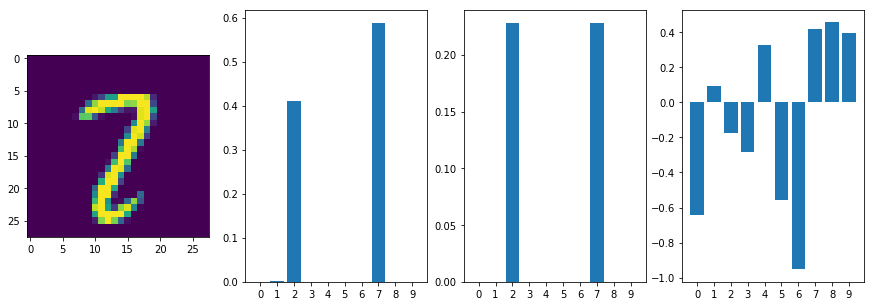

Correct: 6
Predicted: 0


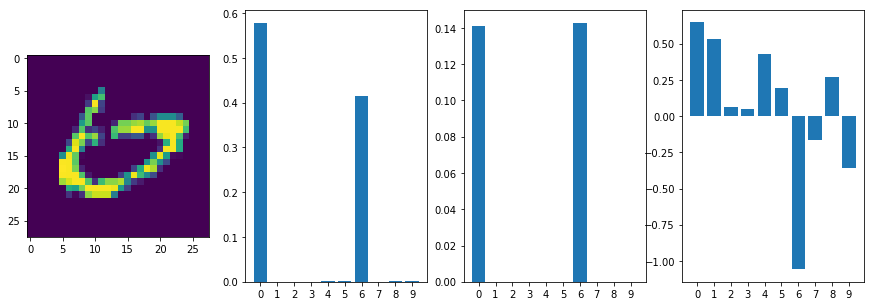

Correct: 8
Predicted: 2


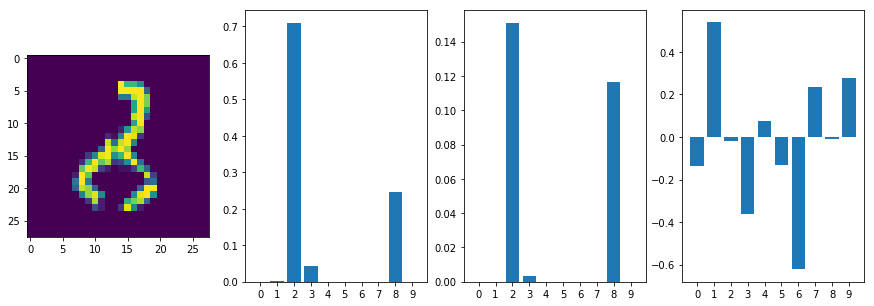

Correct: 8
Predicted: 9


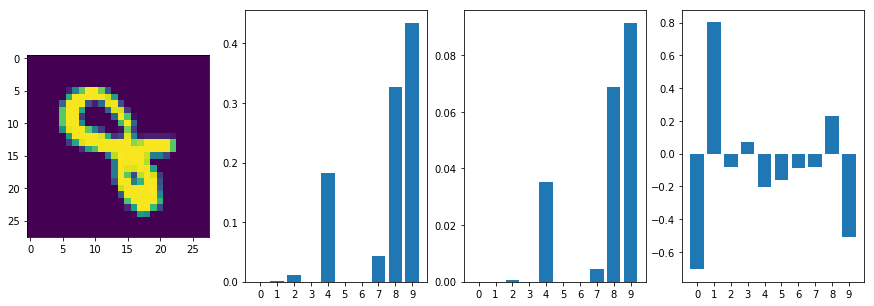

Correct: 4
Predicted: 9


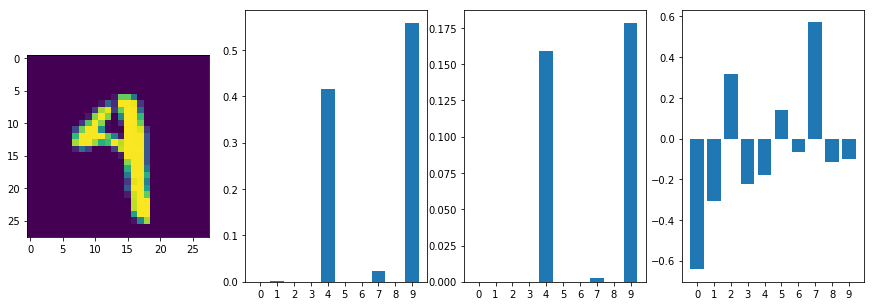

Correct: 8
Predicted: 9


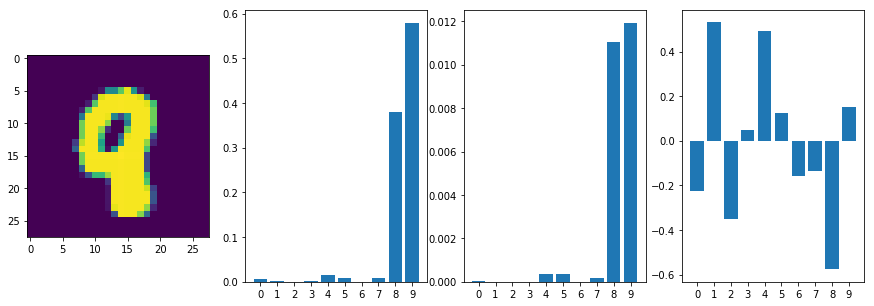

Correct: 6
Predicted: 0


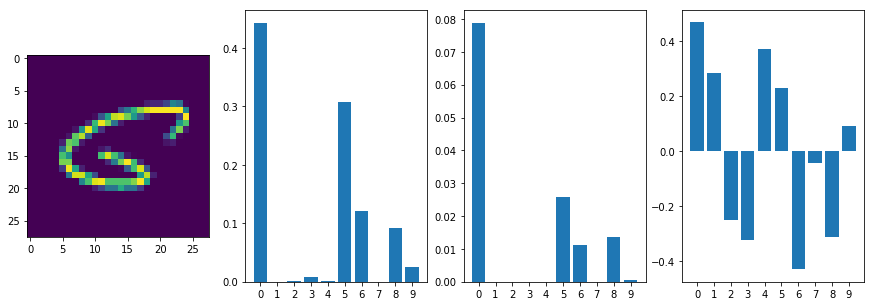

Correct: 5
Predicted: 6


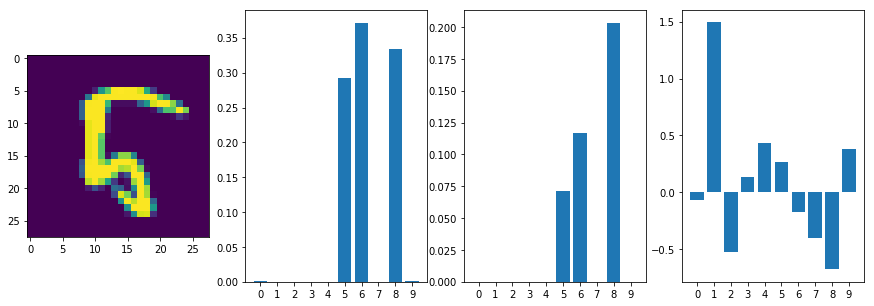

Correct: 7
Predicted: 2


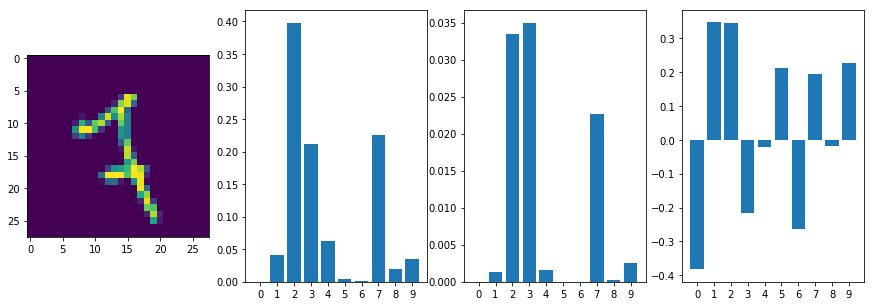

Correct: 3
Predicted: 8


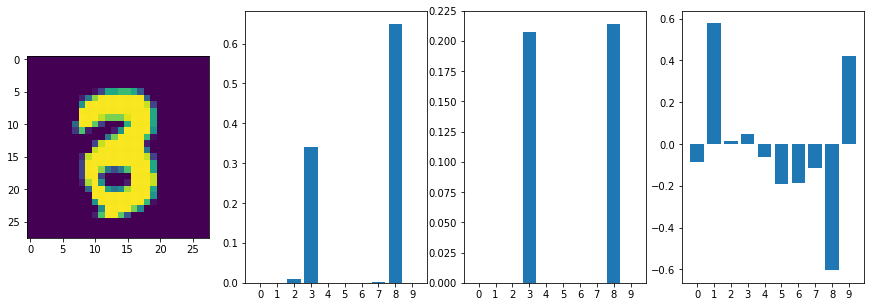

In [8]:
testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

results = []
nR = 5

nwrongs = 0
for i,xydata in enumerate(testloader):
    x,y = xydata
    x = x.repeat(nR,1,1,1).cuda()
    pred_logits, pred_probs, pred_uncer =  M(x)
    mean_pred_probs = torch.mean(pred_probs, dim=0)
    var_pred_probs = torch.var(pred_probs, dim=0)
    mean_pred_uncer = torch.mean(pred_uncer, dim=0)
#     print(x.shape, pred_probs)
#     print(y, torch.argmax(mean_pred_probs).item())
    
    if nwrongs < 10:
        if y.item() != torch.argmax(mean_pred_probs).item():
            nwrongs += 1
            print("Correct: " + str(y.item()))
            print("Predicted: " + str(torch.argmax(mean_pred_probs).item()))
            show_with_var(
                x.cpu().numpy()[0,0,:,:], 
                mean_pred_probs.detach().cpu().numpy(), 
                var_pred_probs.detach().cpu().numpy(),
                mean_pred_uncer.detach().cpu().numpy()
            )



# for i in xrange(10):
#     x_batch, y_batch = mnist.test.next_batch(100)
#     # Use tile instead of repeat, because np.repeat flattens results
#     x_batch_multipass = np.tile(x_batch, n_passes).reshape(-1, 784)


#     pred_y_multipass = sess.run(class_prob, feed_dict={
#         x_data: x_batch_multipass, dropout_rate_data: 0.5})

#     pred_y_multipass = pred_y_multipass.reshape(-1, n_passes, 10)
#     pred_y_mean = pred_y_multipass.mean(axis=1)
#     pred_y_var = pred_y_multipass.var(axis=1)

#     acc = sess.run(accuracy, feed_dict={
#         x_data: x_batch, y_data:y_batch, dropout_rate_data: 0.5})
    
#     wrong_idx = np.where(np.equal(np.argmax(y_batch, axis=1), np.argmax(pred_y_mean, axis=1)) == False)[0]
#     if len(wrong_idx) > 0:
#         for idx in np.nditer(wrong_idx):
#             print("Correct: " + str(np.argmax(y_batch[idx])))
#             print("Predicted: " + str(np.argmax(pred_y_mean[idx])))
#             show_with_var(x_batch[idx], pred_y_mean[idx], pred_y_var[idx])

Correct: 7
Predicted: 4


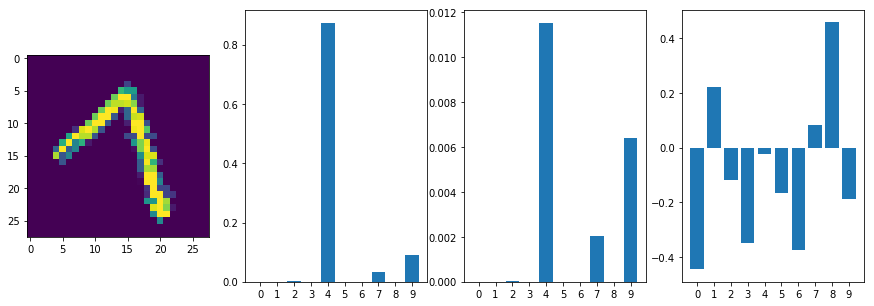

Correct: 2
Predicted: 0


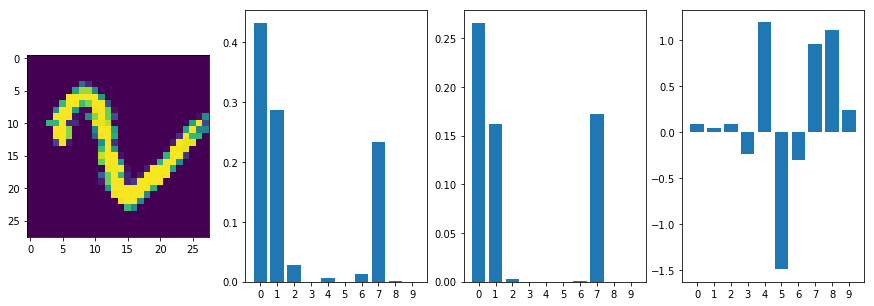

Correct: 9
Predicted: 5


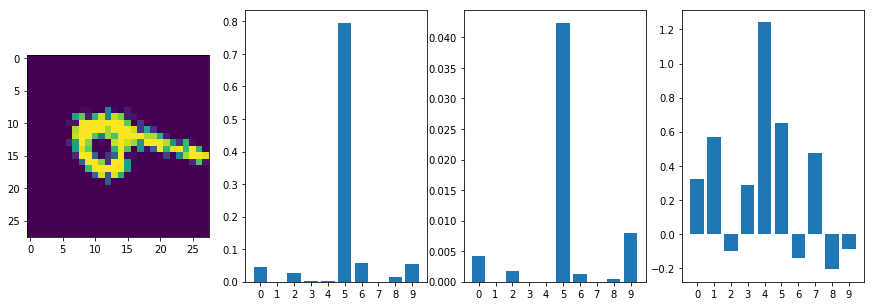

Correct: 5
Predicted: 6


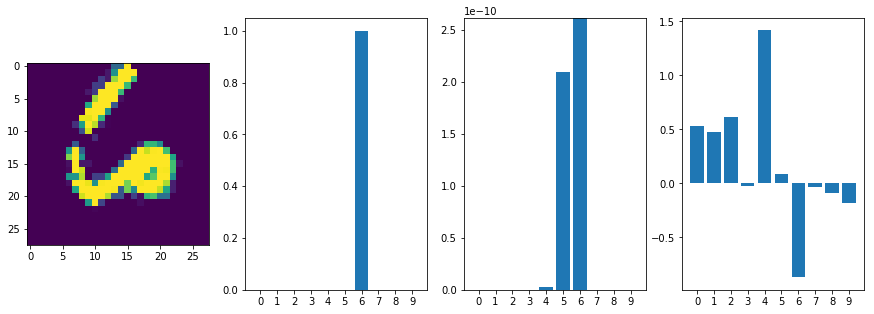

Correct: 9
Predicted: 4


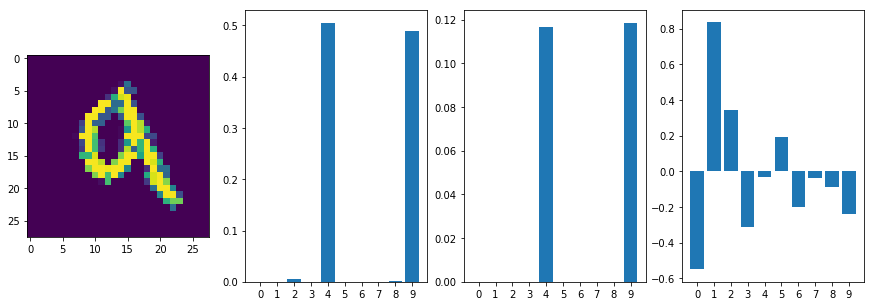

Correct: 1
Predicted: 3


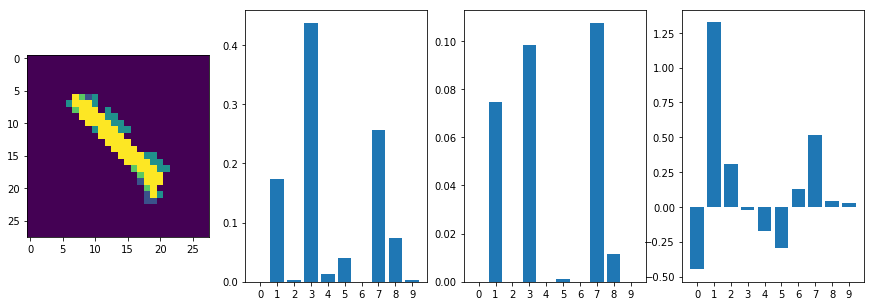

Correct: 7
Predicted: 9


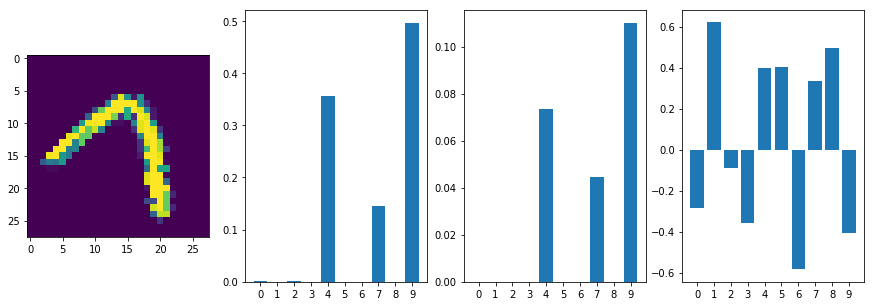

Correct: 3
Predicted: 0


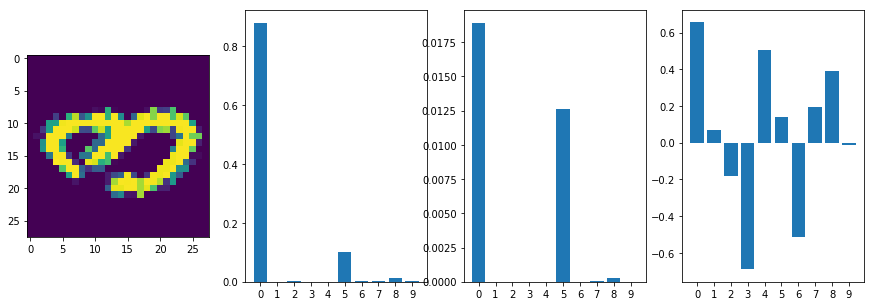

Correct: 4
Predicted: 2


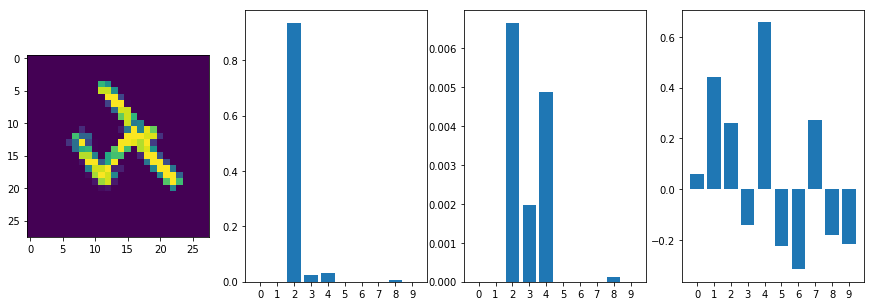

Correct: 9
Predicted: 4


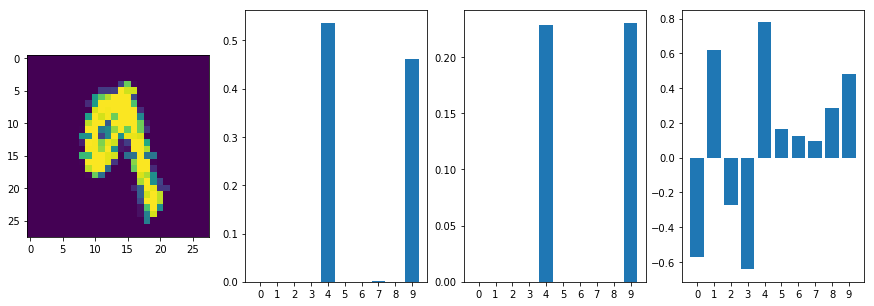

In [10]:
transform_rot = transforms.Compose(
    [
        lambda x : x.rotate(45),
        transforms.ToTensor(),
        lambda x : (x-x.min())/(x.max()-x.min()),
        lambda x : x.float()
    ]
)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform_rot)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

results = []
nR = 5

nwrongs = 0
for i,xydata in enumerate(testloader):
    x,y = xydata
    x = x.repeat(nR,1,1,1).cuda()
    pred_logits, pred_probs, pred_uncer =  M(x)
    mean_pred_probs = torch.mean(pred_probs, dim=0)
    var_pred_probs = torch.var(pred_probs, dim=0)
    mean_pred_uncer = torch.mean(pred_uncer, dim=0)
#     print(x.shape, pred_probs)
#     print(y, torch.argmax(mean_pred_probs).item())
    
    if nwrongs < 10:
        if y.item() != torch.argmax(mean_pred_probs).item():
            nwrongs += 1
            print("Correct: " + str(y.item()))
            print("Predicted: " + str(torch.argmax(mean_pred_probs).item()))
            show_with_var(
                x.cpu().numpy()[0,0,:,:], 
                mean_pred_probs.detach().cpu().numpy(), 
                var_pred_probs.detach().cpu().numpy(),
                mean_pred_uncer.detach().cpu().numpy()
            )



# for i in xrange(10):
#     x_batch, y_batch = mnist.test.next_batch(100)
#     # Use tile instead of repeat, because np.repeat flattens results
#     x_batch_multipass = np.tile(x_batch, n_passes).reshape(-1, 784)


#     pred_y_multipass = sess.run(class_prob, feed_dict={
#         x_data: x_batch_multipass, dropout_rate_data: 0.5})

#     pred_y_multipass = pred_y_multipass.reshape(-1, n_passes, 10)
#     pred_y_mean = pred_y_multipass.mean(axis=1)
#     pred_y_var = pred_y_multipass.var(axis=1)

#     acc = sess.run(accuracy, feed_dict={
#         x_data: x_batch, y_data:y_batch, dropout_rate_data: 0.5})
    
#     wrong_idx = np.where(np.equal(np.argmax(y_batch, axis=1), np.argmax(pred_y_mean, axis=1)) == False)[0]
#     if len(wrong_idx) > 0:
#         for idx in np.nditer(wrong_idx):
#             print("Correct: " + str(np.argmax(y_batch[idx])))
#             print("Predicted: " + str(np.argmax(pred_y_mean[idx])))
#             show_with_var(x_batch[idx], pred_y_mean[idx], pred_y_var[idx])